# Election Model Scoring

Alex Huth, 11/9/2016

Okay so this whole election thing ended up much more depressing than I expected. Or most people expected, for that matter. Now we know that many of the polls were wrong, and the models based on those polls were also wrong. But how wrong? And, most importantly, _who was most wrong?_ (That's definitely a joke, in no way is this the most important issue right now. I thought I'd be writing about this in a happier timeline.)

In this notebook I used a pretty simple scoring method to compare how well six popular public election models performed: **FiveThirtyEight**, **Princeton Election Consortium**, **New York Times**, **PredictWise**, **Huffington Post**, and **Daily Kos**. I'll first walk you through the scoring method, then show you the results.

### _Electoral Golf_
Each model assigned a probability to each outcome (i.e. how each state voted, and who won the electoral college). Using those numbers, we can compute the probability of the actual outcome (e.g. Trump won Michigan) under each model. I'll call this the _likelihood_ of the actual result under the model. Assuming that the events are independent (which they aren't, but let's go with that for now and I'll explain how that changes things later) we can multiply together the likelihoods from each state to get a single number for the likelihood of _all_ the results under the model. But the problem with doing this is that it ends up with annoyingly tiny numbers. So instead of multiplying the probabilities, I'm going to take the logarithm of the likelihood, and then add those logarithms together. This will give us nicer numbers. 

To be specific, the score I'm giving each prediction is going to be this (this looks messy and math-y, but I think it makes the results nicely interpretable--bear with me!):

$$ Score = -10 \log_2(\Pr(result)) $$

Since I'm using the negative logarithm, _lower scores are better_ (like golf!). The best possible model--one where you predict every result accurately with 100% certainty--would give you a whopping zero points. If your prediction of a result is exactly at chance--50/50--then you're going to get exactly 10 points regardless of the outcome (think of this like par--you really shouldn't be doing worse than 10 points on any one prediction). 

If your prediction is worse than chance (e.g. you predict there's a 10% chance of the actual outcome), then your score will be greater than 10 (actually 33.2 if you predicted 10%). If your prediction is better than chance (e.g. you give a 90% chance to the actual outcome), then your score will be less than 10.

If you happen to predict _exactly_ wrong--giving a 0% chance to the actual outcome--then you gain **infinity points**. So you should try to avoid that.

Let's look at an example. FiveThirtyEight gave Clinton a 20.8% chance of losing Michigan. Trump won Michigan. So FiveThirtyEight's score for Michigan is around 22.7 points. Worse than par (which is 10 points), but not insanely bad.

### _How the sausage is made_
Okay now there's going to be some code that loads the predictions and computes the scores. Feel free to skip down to the results, or read the code if you want to see how the sausage is made.

In [226]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [373]:
from matplotlib.pyplot import *
import numpy as np
import pandas

# from the NYT election prediction site -- thanks for putting all this data together, NYT!
ratings = np.recfromcsv('comparison-table.csv')

In [384]:
# Actual results. True = R won state
# I'm skipping district-level results for ME and NE for now, since some models are missing them
result = dict([('ak', True),
               ('al', True),
               ('ar', True),
               ('az', True),
               ('ca', False),
               ('co', False),
               ('ct', False),
               ('dc', False),
               ('de', False),
               ('fl', True),
               ('ga', True),
               ('hi', False),
               ('ia', True),
               ('id', True),
               ('il', False),
               ('in', True),
               ('ks', True),
               ('ky', True),
               ('la', True),
               ('ma', False),
               ('md', False),
               ('me', False),
               #('me-1', False),
               #('me-2', True),
               ('mi', True),
               ('mn', False),
               ('mo', True),
               ('ms', True),
               ('mt', True),
               ('nc', True),
               ('nd', True),
               ('ne', True),
               #('ne-1', True),
               #('ne-2', True),
               #('ne-3', True),
               ('nh', False),
               ('nj', False),
               ('nm', False),
               ('nv', False),
               ('ny', False),
               ('oh', True),
               ('ok', True),
               ('or', False),
               ('pa', True),
               ('ri', False),
               ('sc', True),
               ('sd', True),
               ('tn', True),
               ('tx', True),
               ('us', True),
               ('ut', True),
               ('va', False),
               ('vt', False),
               ('wa', False),
               ('wi', True),
               ('wv', True),
               ('wy', True)])

In [385]:
#states = np.setdiff1d(np.unique(ratings['state']), ['us'])
states = np.setdiff1d(result.keys(), ['us'])

In [387]:
slugs = np.unique(ratings['slug']) # slug = model name. NYT terminology
print slugs

['cook' 'dailykos' 'fte' 'huffpost' 'nyt' 'pec' 'predictwise' 'rothenberg'
 'sabato']


In [388]:
# Compute the scores!
lls = []
us_lls = []
scored_slugs = []

for slug in slugs:
    slug_ratings = ratings[ratings['slug']==slug]
    # check if given probabilities
    if np.all(slug_ratings['repprob'] == 'NA'):
        print "No probabilities for %s, skipping.." % slug
        continue
    
    scored_slugs.append(slug)
    
    # compute log likelihoods for each state result
    ll = []
    for state in states:
        r = slug_ratings[slug_ratings['state']==state][0]
        
        if result[r['state']]: # if R
            ll.append(-10 * np.log2(float(r['repprob'])))
        else:
            ll.append(-10 * np.log2(1 - float(r['repprob'])))
    
    lls.append(np.array(ll))
    
    # compute log likelihood for national result
    us_r = slug_ratings[slug_ratings['state']=='us'][0]['repprob']
    if result['us']:
        us_lls.append(-10 * np.log2(float(us_r)))
    else:
        us_lls.append(-10 * np.log2(1 - float(us_r)))


No probabilities for cook, skipping..
No probabilities for rothenberg, skipping..
No probabilities for sabato, skipping..


In [389]:
scores = np.array([np.sum(l) for l in lls])
us_scores = np.array(us_lls)

# _National election result_
Okay here we go. First let's look at the national result. Trump won the electoral college. None of the models predicted this (all of them gave him a below 50% chance), but some were farther off than others.

In [376]:
zip(scored_slugs, us_scores)

[('dailykos', 36.733706168346018),
 ('fte', 18.14006629930034),
 ('huffpost', 58.225541498851953),
 ('nyt', 26.690515800777398),
 ('pec', inf),
 ('predictwise', 30.588936890535688)]

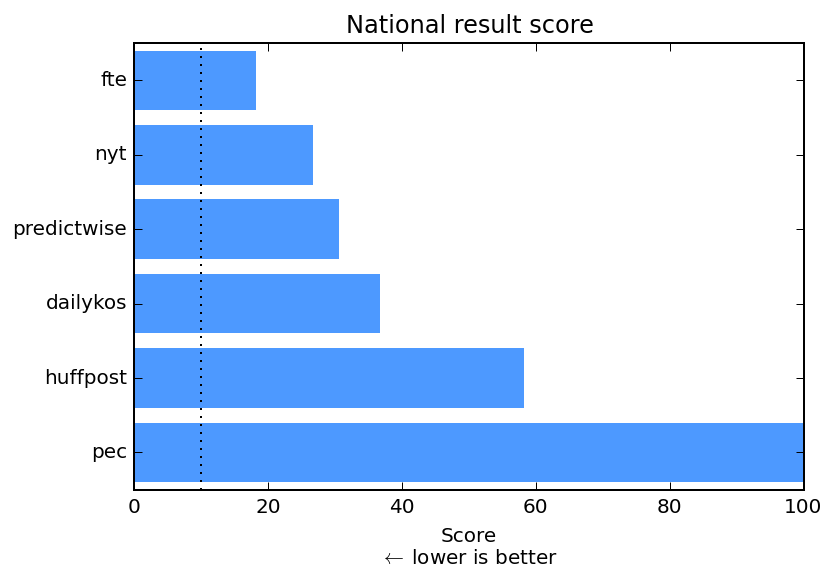

In [378]:
us_sort = np.argsort(us_scores)[::-1]
us_scores[np.isinf(us_scores)] = 1e5 # pec's score is infinity

bar(left=0, height=0.8, bottom=range(len(scored_slugs)), width=us_scores[us_sort], 
    align='center', orientation='horizontal',
   edgecolor='none', color=(0.3, 0.6, 1.0))
yticks(range(len(scored_slugs)), np.array(scored_slugs)[us_sort], rotation=0);
xlabel("Score\n$\leftarrow$ lower is better");
title('National result score');
xlim(0, 100);
vlines(10, -0.5, len(scored_slugs)-0.5, linestyle=':', color='k');

The vertical line here is par (10 points, or a 50/50 call). Since everyone predicted a Clinton win, all the scores are higher than 10 points. In fact, the Princeton Election Consortium (PEC) model was so certain that Clinton was going to win that they gave her a 100% chance. Their score here is literally **infinity points**. This is the worst possible error someone can make. So.. that model was wrong.

Among the other models, FiveThirtyEight came out on top. This should probably be no surprise, since Nate Silver has been excoriating other modelers (notably PEC's Sam Wong) for irrational certainty in their models. I'm not going to say more about the others, except that HuffPo faired pretty poorly here.

# _State-by-state Results_
Now let's look at the state-by-state results. I've computed the sum of the scores for each model and will show that first.

In [367]:
zip(scored_slugs, scores)

[('dailykos', 374.43803279607272),
 ('fte', 160.06921474191904),
 ('huffpost', 287.66592819028131),
 ('nyt', 188.77936148716242),
 ('pec', 161.45923022027532),
 ('predictwise', 197.92609387877761)]

Here I want to note that computing "par" for the total state-by-state score was tricky and the number I'm giving is kind of fuzzy. I've assumed that some states are easy to call (e.g. calling Hawaii for Clinton or Alabama for Trump at 100% is a pretty safe move), while others are trickier. I could've manually set a list of "easy call" states, but that would've been _hard_. So instead I'm just saying that a state was an easy call if the *worst* model got less than 1 point (i.e. called it with at least 93% certainty). It turns out there were 28 states (including DC) that were "obvious" calls. That leaves 23 states that I'm putting in the "tossup" category. A pretty stupid model could just have called the 28 obvious states at 100% and then put 50/50 odds on the rest. That model would get 230 points pretty much regardless of the outcome (unless one of the "obvious" states flipped, but that's obviously unlikely). So I'm calling 230 points "par" for the state-by-state results.

In [392]:
num_obvious = (np.array(lls).max(0) < 1).sum()
num_tossup = len(states) - num_obvious
par = num_tossup * 10
print "Par:", par

Par: 230


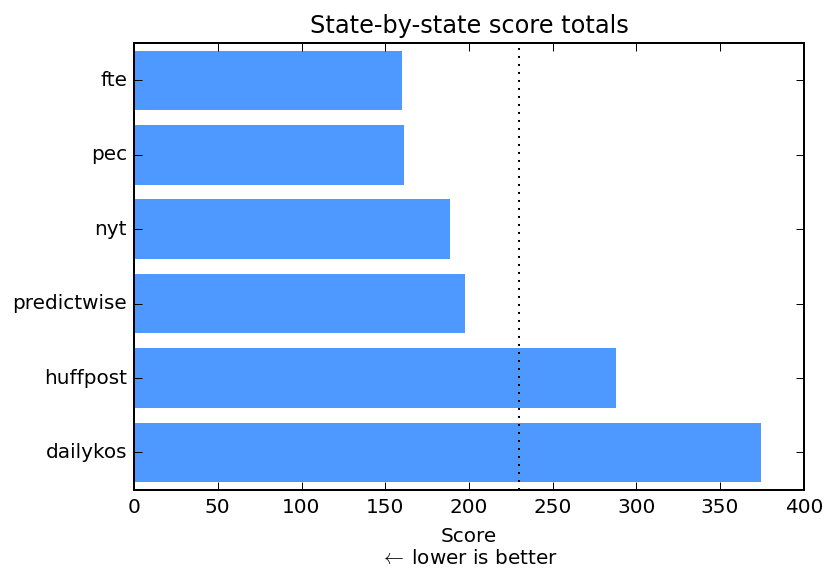

In [394]:
sort = np.argsort(scores)[::-1]

bar(left=0, height=0.8, bottom=range(len(scored_slugs)), width=scores[sort], align='center', orientation='horizontal',
   edgecolor='none', color=(0.3, 0.6, 1.0))
yticks(range(len(scored_slugs)), np.array(scored_slugs)[sort], rotation=0);
xlabel("Score\n$\leftarrow$ lower is better");
title('State-by-state score totals');
vlines(par, -0.5, len(scored_slugs)-0.5, linestyle=':', color='k');

Again the vertical line here is par (230 points in this case). Like the national result, FiveThirtyEight was the best model among the pack, with only 160 points in total. Surprisingly (given the national result), PEC is only slightly worse here, with 161 points. (How the hell does that happen? How did PEC predict the state-by-state results about as well as anyone else but predic the national result disastrously wrong? Thoughts below.) FTE and PEC are followed pretty narrowly by the New York Times at 189 points and PredictWise at 198 points. All four of these models beat par of 230 points, meaning that they called the 23 "tossup" states at a better than chance rate.

But two of the models were below par. HuffPo is at 288 points, repeating their failure in the national result. And Daily Kos did terribly with 374 points.

How did these errors manifest? What kind of mistakes were made? I think we'll get a better idea by looking at individual state-by-state scores.

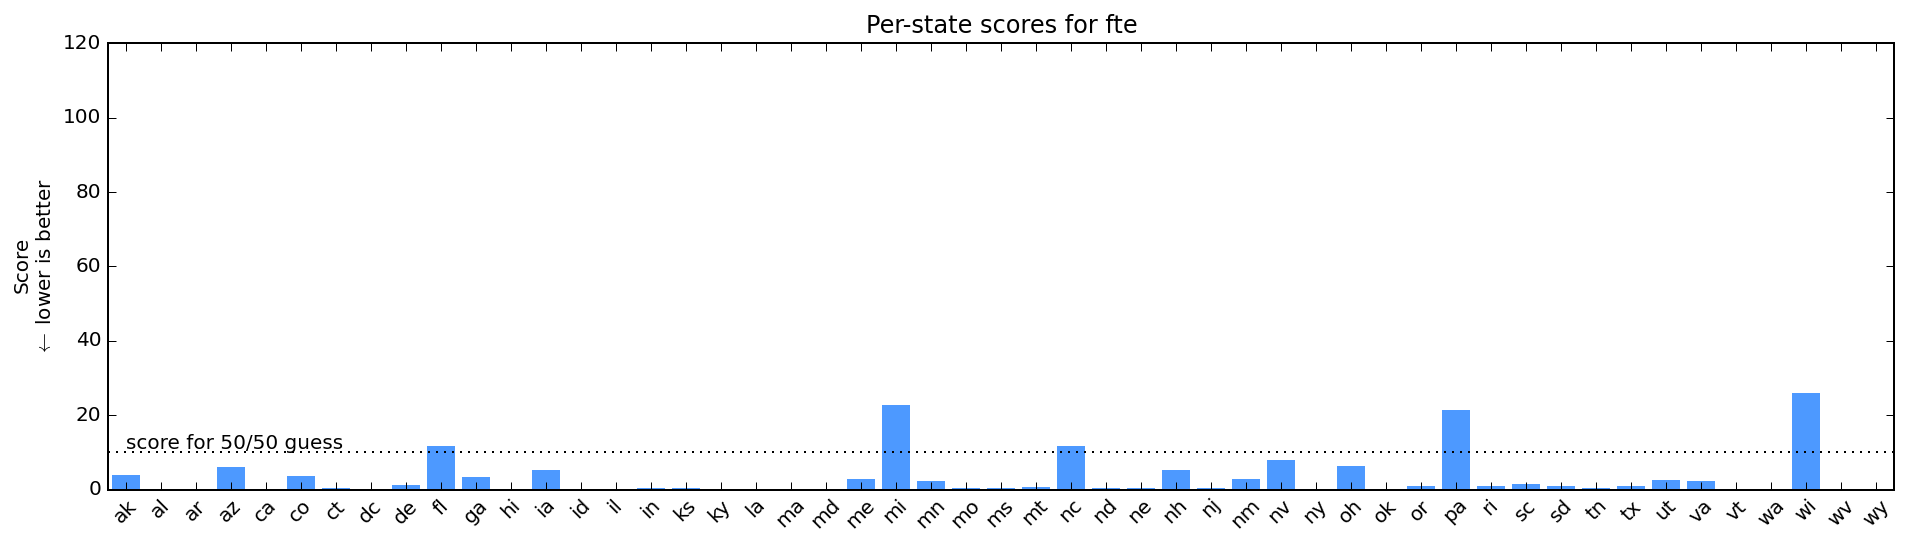

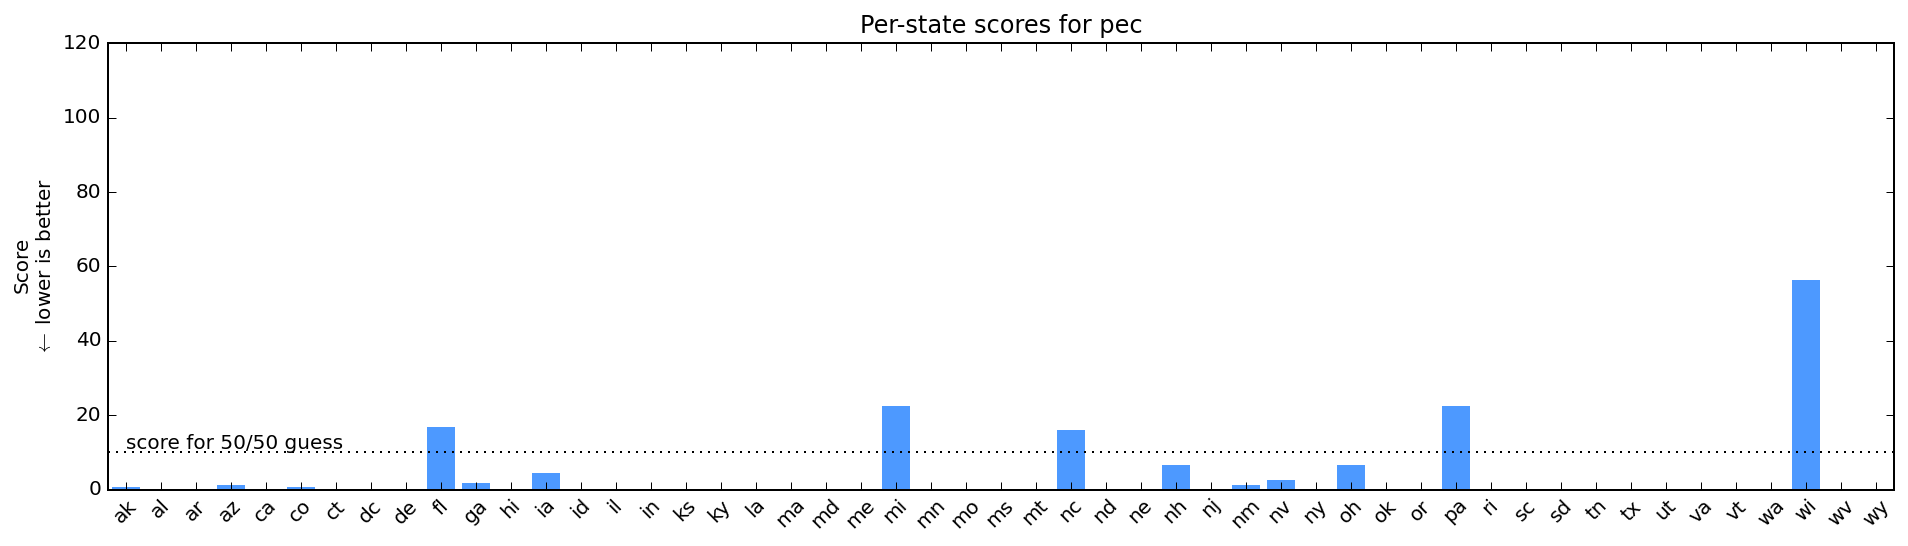

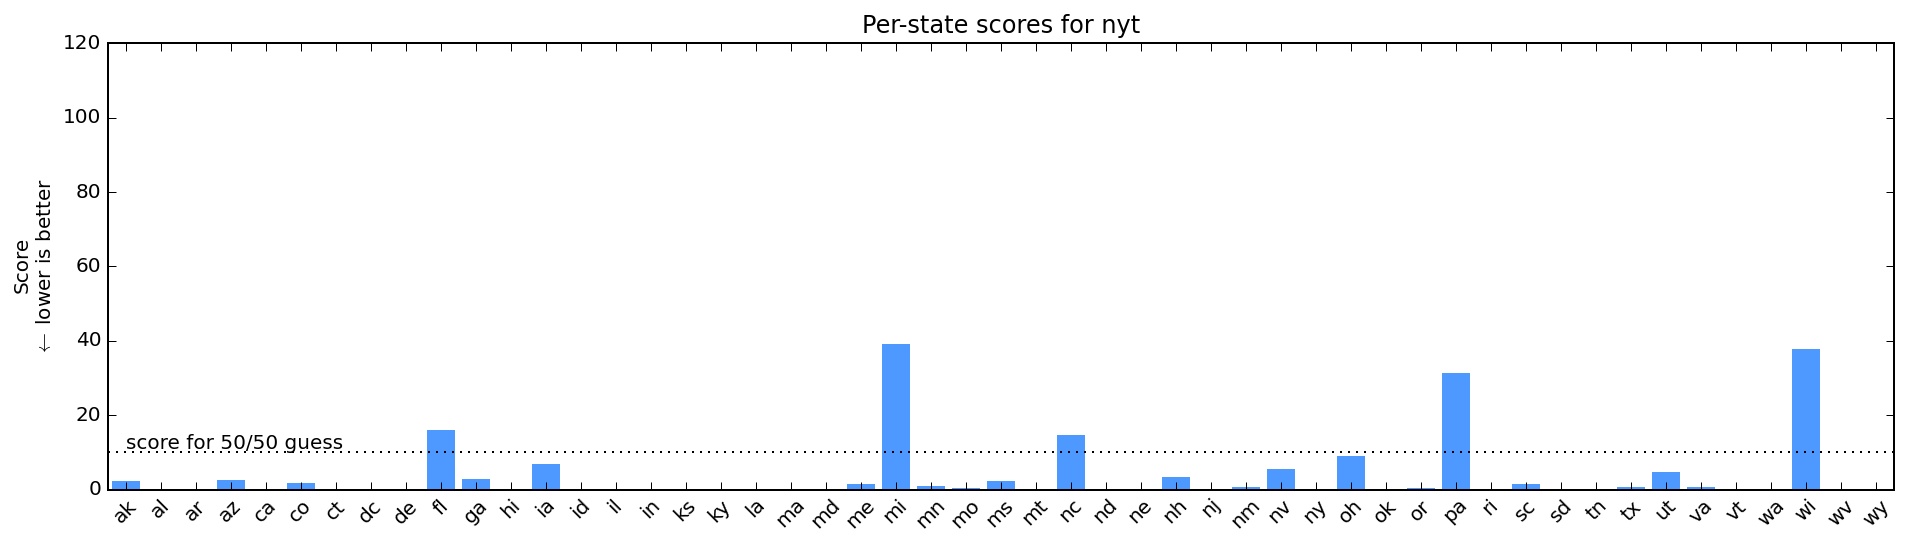

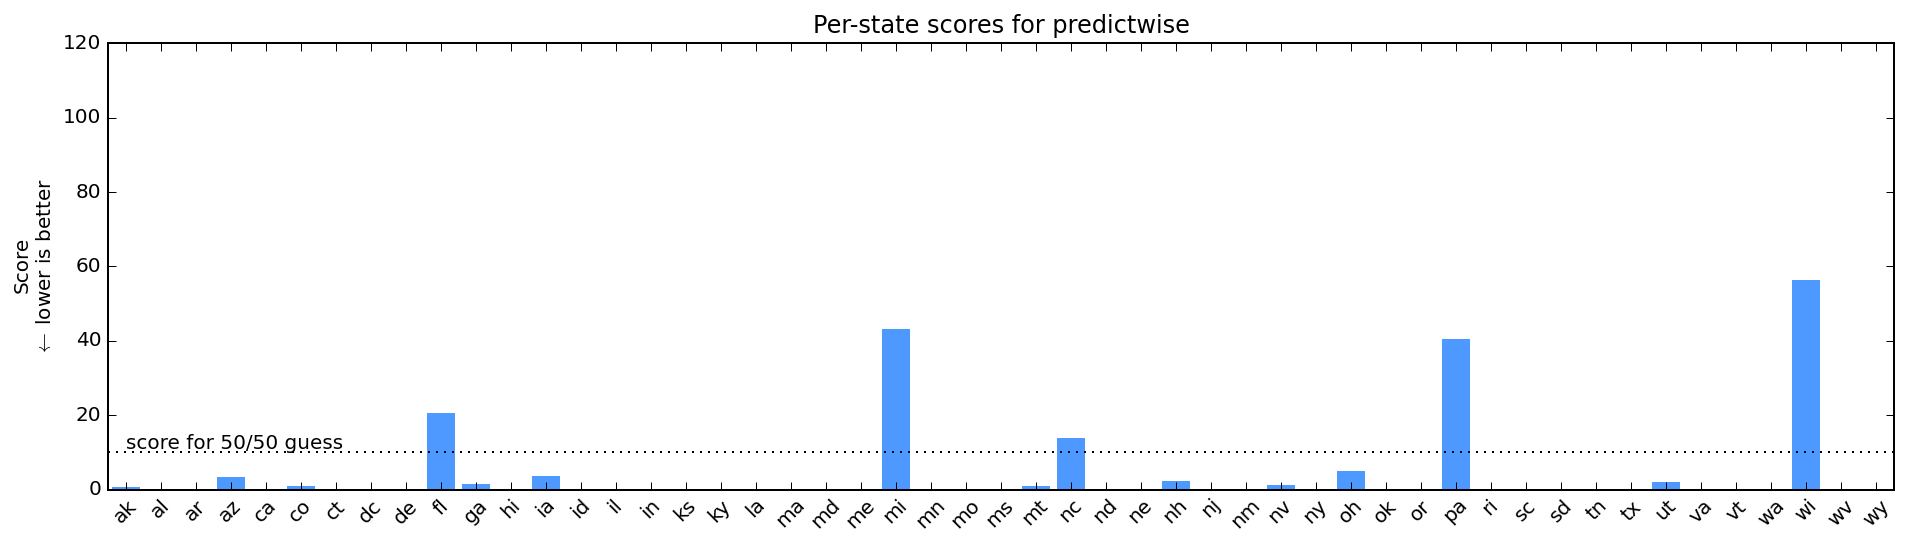

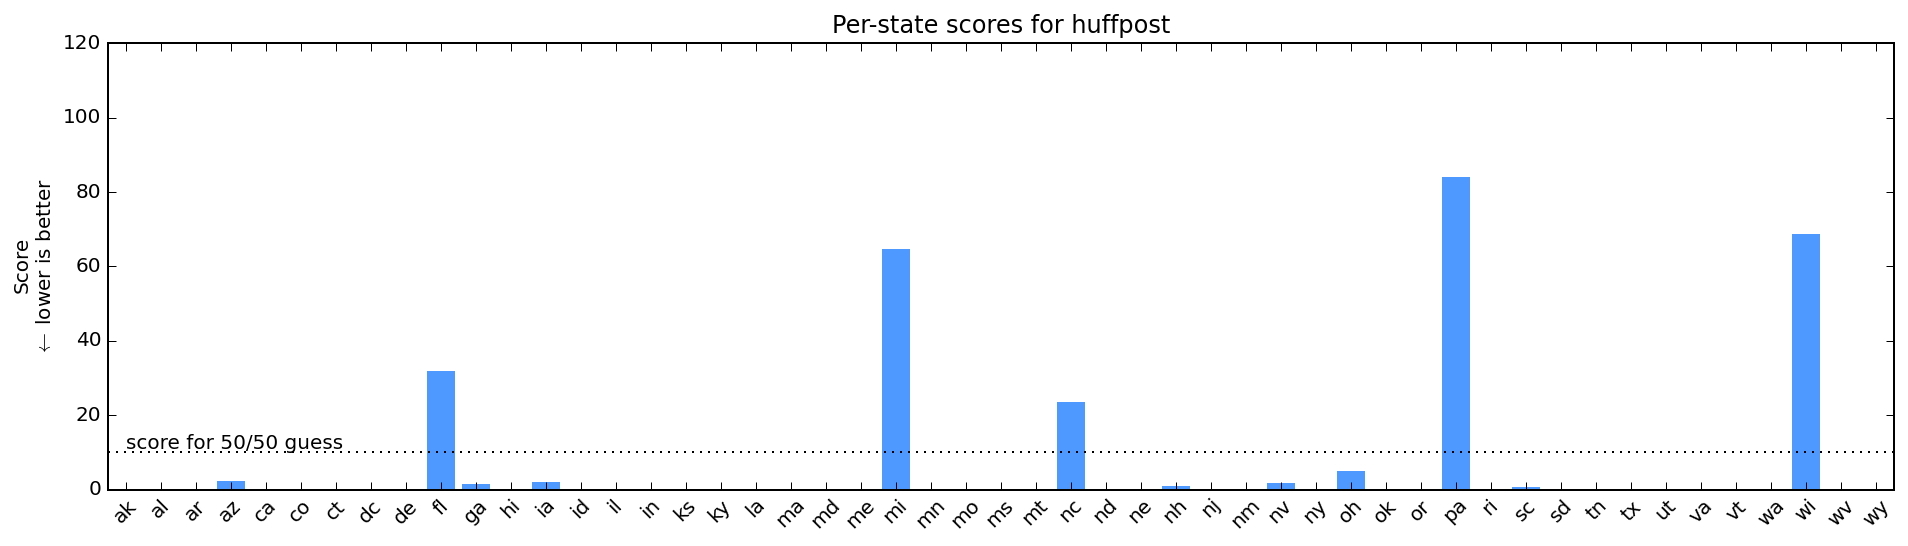

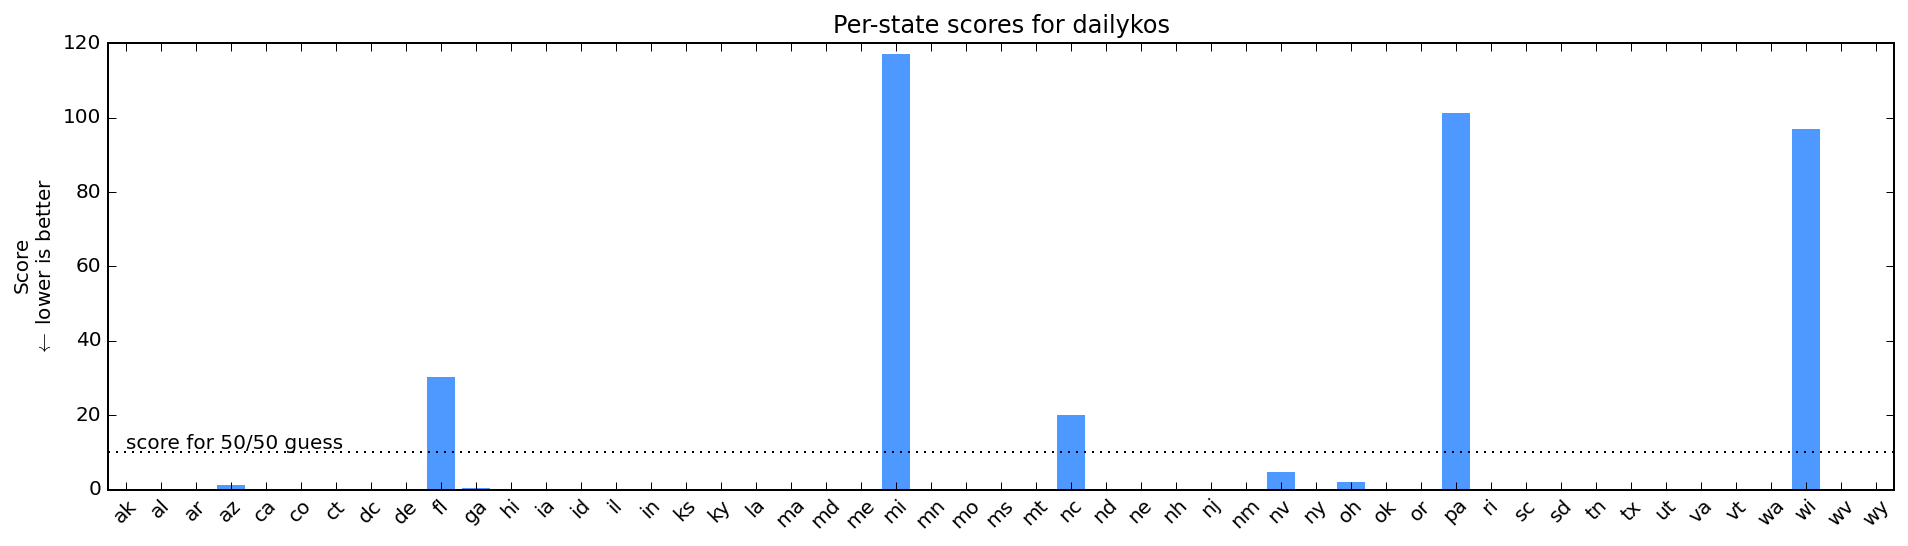

In [396]:
for sel in sort[::-1]:
    figure(figsize=(16,4))
    title('Per-state scores for %s' % scored_slugs[sel])
    bar(range(len(states)), lls[sel], align='center', edgecolor='none', color=(0.3, 0.6, 1.0))
    xticks(range(len(states)), states, rotation=45);
    hlines(10.0, -0.5, len(states)-0.5, linestyle=':', color='k')
    xlim(-0.5, len(states)-0.5)
    #text(len(states)-1, 10.0, "score for 50/50 guess", ha='right', va='bottom')
    text(0, 10.0, "score for 50/50 guess", ha='left', va='bottom')
    ylabel("Score\n$\leftarrow$ lower is better")
    ylim(0, 120);

Here I'm showing the score for each model in each state, with par (50/50 guess) marked by a dotted line. What I see here is a really consistent pattern: everybody missed on FL, MI, NC, PA, and WI. The only difference is in how much they missed. FTE was conservative with their probabilities, so when they missed they didn't accrue that many points. Their worst call--Wisconsin--only got them 26 points (they gave Clinton a 16.5% chance of losing there). Of course this conservatism didn't uniformly help FTE, it also hurt them on some states that others called with more certainty. For example in Alaska they only gave Trump a 76% chance of winning, netting them 3.9 points, while other models were much more certain of Trump's win there.

Obviously the worst model here is Daily Kos, which got a whopping 117 points for the mis-call on Michigan (they gave Clinton less than 1% chance of losing there!), 101 points for Pennsylvania, and 97 points for Wisconsin. Clearly their model overstated the certainty of the polls, and failed as a result.

# _Why did these models fail?_
First, I really believe that no model could've made the right call here. All these models are based on data, and in this case the data (the polls) were simply wrong. Garbage in, garbage out. All these models' calls were in the same directions--nobody predicted one state to go a different way than any other model. But there is still a clear difference between how the models performed. What gives? 

I don't know all the details of thow these models work--heck I practically don't know anything about them at all. But I know a bit about probabilistic models in general. It's pretty clear that the failure mode here was how these models handle uncertainty in the data, and how they propagate that uncertainty to the model predictions. 

I think the key concept here is **independence**. Each poll that goes into these models gives some sense of what the electorate are going to do. Each poll is limited in its scope, and thus has some built-in uncertainty (usually called margin of error). If you assume that the results of each poll are _independent_ of the results from other polls, then when you average the results together, the uncertainty shrinks pretty quickly (usually with something like the square root of the number of polls you're averaging). That's great! If it's true. If the polls are _not independent_, then the _true_ uncertainty in their average shrinks much more slowly. This is because non-independent polls have correlated errors.

When you're building a model, assuming things are independent is easy. If you assume two measurements are independent, then there are simple ways to estimate your uncertainty. Much of the classical probability theory and statistics that we learn in high school and college explicitly assumes independence. 

On the other hand, building a model were you assume things are non-independent is _really hard_. You can't just throw things together anymore, you usually have to also estimate _how_ they are non-independent. Are they positively correlated? Negatively correlated? By how much? And estimating all these dependencies among your variables isn't just hard conceptually, it requires a lot more data. In some cases it might require data that simply isn't available (e.g. if all the polls are biased relative to actual election results.. how the hell do you know that ahead of time?).

Nate Silver's talked a lot about estimating dependencies among polling errors, and it seems like that has (despite the overall negative result) paid off in FTE's model. They don't assume that the error in each state is independent, but instead assume that some states will make the same errors as each other (such as the rust belt states in which Trump wildly overperformed relative to his polls). That seems to be the right approach here, although clearly in this case it just wasn't sufficient to actually predict the outcome of the election. The other modelers clearly have a lot to learn about estimating uncertainty and independence of errors. It's hard, but it's important!

**One final note:** when I computed these scores, you might remember that I assumed that the result in each state was independent. If you've read this far you should realize that's just wrong. If I were doing this right, I'd try to get some estimate of how correlated the errors were in different states, and then use that to adjust the scores. How would that affect things? Ironically, it would probably make all the models look _better_, because I imagine that the vital errors in MI, WI, and PA are not independent. So instead of saying "wow this model got PA wrong! and MI wrong! and WI wrong! it's terrible!", our scoring method might be better off saying "wow this model got the upper midwest/rustbelt wrong! it's pretty bad!".

# _Addendum: Just Uncertainty?_
In the discussion above I argued that most of the differences between the models just comes down to uncertainty: the FTE model was much more uncertain, while, for example, the Daily Kos model was very certain. Both predicted the same outcome, but FTE was just less bullish about it. This made the FTE model look pretty good.

So an idea occurs: if we just make the models less certain, does that eliminate the differences between them? I can do this by _smoothing_ the probabilities, pushing them all toward 0.5. We can control the amount of smoothing by adjusting the smoothing parameter, $\alpha$. I used this formula to compute the smoothed probability, $\hat{p}$, from the original probability, $p$, and the smoothing parameter:

$$\hat{p} = \frac{p + 0.5 \alpha}{1 + \alpha}$$

You should see that setting $\alpha$ to something really high will make $\hat{p}$ equal to almost exactly 0.5. Let's see how this works.

In [548]:
# Compute the scores with smoothing

alphas = np.linspace(0, 0.4, 500) # the range of smoothing values
smooth_lls = []

for slug in scored_slugs:
    slug_ratings = ratings[ratings['slug']==slug]
    
    # compute log likelihoods for each state result
    ll = []
    for state in states:
        r = slug_ratings[slug_ratings['state']==state][0]
        
        if result[r['state']]: # if R
            ll.append(-10 * np.log2((float(r['repprob']) + 0.5 * alphas) / (1 + alphas)))
        else:
            ll.append(-10 * np.log2((1 - float(r['repprob']) + 0.5 * alphas) / (1 + alphas)))
    
    smooth_lls.append(np.array(ll))

In [549]:
smooth_ll_arr = np.array(smooth_lls)
print smooth_ll_arr.shape # models x states x smoothing params

(6, 51, 500)


In [550]:
smooth_ll_sum = smooth_ll_arr.sum(1)
best_alpha_inds = smooth_ll_sum.argmin(1)

In [551]:
print "Best smoothing factor & score for each model"
print "-"*47
for stuff in zip(scored_slugs, alphas[best_alpha_inds], smooth_ll_sum[range(6),best_alpha_inds], smooth_ll_sum[:,0]):
    print "%-12s: alpha=%0.2f -> score=%0.2f (orig score=%0.2f)" % stuff

Best smoothing factor & score for each model
-----------------------------------------------
dailykos    : alpha=0.16 -> score=214.19 (orig score=374.44)
fte         : alpha=0.00 -> score=160.07 (orig score=160.07)
huffpost    : alpha=0.15 -> score=219.65 (orig score=287.67)
nyt         : alpha=0.00 -> score=188.78 (orig score=188.78)
pec         : alpha=0.01 -> score=160.94 (orig score=161.46)
predictwise : alpha=0.06 -> score=191.79 (orig score=197.93)


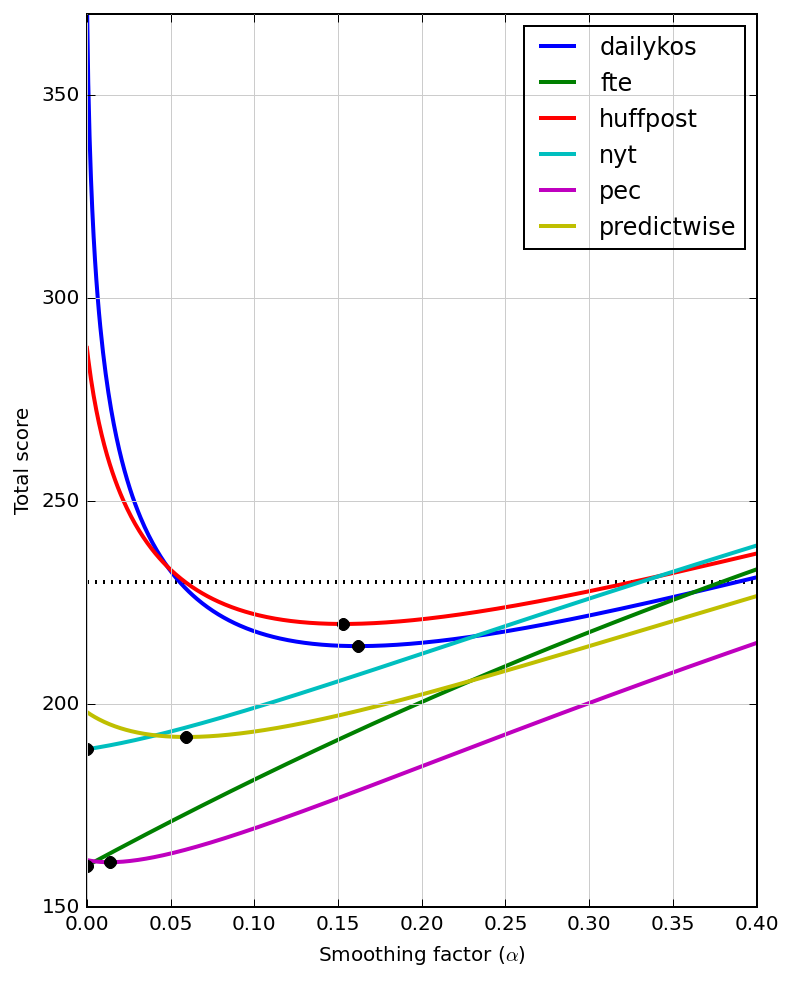

In [552]:
figure(figsize=(6,8))
lines = plot(alphas, smooth_ll_sum.T, '-', lw=2);
grid(linestyle='-', color='0.8'); ylim(150, 370); xlim(0, alphas[-1]); 
legend(lines, scored_slugs);
plot(alphas[best_alpha_inds], smooth_ll_sum[range(6),best_alpha_inds], 'o');
xlabel(r"Smoothing parameter ($\alpha$)")
ylabel("Total score");
hlines(230, 0, alphas[-1], linestyles=':', lw=2);

Here I plotted the total state-by-state score for each model as a function of the smoothing parameter, $\alpha$. The 'par' that I defined earlier is plotted as a dotted line at 230 points. Black dots mark the best smoothing parameter for each model.

This result was much more interesting than I thought. For one, the ordering of the models almost doesn't change at all. Although the differences between them are smaller with smoothing (best to worst is now 160 to 220 instead of 160 to 374), there are still substantial differences in how well these models fair. I think this means that there are still some insights and clever ideas baked into some of these models (notably FTE and PEC) that make them fundamentally better than the others.

Only Daily Kos and HuffPo switch spots on the leaderboard, with the smoothed Daily Kos doing slightly better (and both under par!). Both of those models improved a _lot_ with smoothing: Daily Kos went from 374 to 214 points, and HuffPo from 288 to 220. This suggests that these models were just really overconfident, and even a simple correction to their estimates would have performed much better. (Although I should also be clear here that this kind of smoothing--especially choosing the smoothing parameter after the fact to get the best score--is totally cheating, and is not something they could have done before.)

Interestingly, two of the models don't need any smoothing at all: both FTE and NYT perform best with no smoothing, meaning that they already had calibrated their amount of uncertainty pretty well. And the PEC model is not far behind, fairing best with only a tiny bit of smoothing.